In [207]:
from pathlib import Path
import pandas as pd
from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs
from carps.analysis.utils import filter_only_final_performance
from carps.analysis.run_autorank import get_df_crit

import logging, sys
logging.disable(sys.maxsize)

original_optimizers = {
    "blackbox": ["RandomSearch", "SMAC3-BlackBoxFacade", "Nevergrad-CMA-ES"],
    "multi-objective": ["RandomSearch", "Optuna-MO", "Nevergrad-DE"],
    "multi-fidelity": ["SMAC3-Hyperband", "SMAC3-MultiFidelityFacade", "DEHB"],
    "multi-fidelity-objective": ["RandomSearch", "SMAC3-MOMF-GP", "Nevergrad-DE"],
}

def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "logs.parquet"
        logs.append(pd.read_parquet(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_parquet(Path(p) / "logs_cfg.parquet") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

scenario = "blackbox"
set_id = "full"
subset_size = 30
paths = ["../runs/SMAC3-BlackBoxFacade", "../runs/RandomSearch", "../runs/Nevergrad-CMA-ES"]
performance_fn = "/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/BB/default/df_crit.csv"

# scenario = "multi-fidelity-objective"
# set_id = "full"
# subset_size = 9
# paths = ["../runs_MOMF/SMAC3-MOMF-GP", "../runs_MOMF/RandomSearch", "../runs_MOMF/Nevergrad-DE"]
# performance_fn = "/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/MOMF/lognorm/df_crit.csv"

# scenario = "multi-objective"
# set_id = "full"
# subset_size = 10
# paths = ["../runs_MO/Optuna-MO", "../runs_MO/RandomSearch", "../runs_MO/Nevergrad-DE"]
# performance_fn = "/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/MO/lognorm/df_crit.csv"

# scenario = "multi-fidelity"
# set_id = "full"
# subset_size = 20
# paths = ["../runs/SMAC3-Hyperband", "../runs/SMAC3-MultiFidelityFacade", "../runs_/DEHB"]

fn = f"../data/{scenario}_{set_id}_logs.parquet"
if Path(fn).is_file():
    df = pd.read_parquet(fn)
else:
    D = []
    for rundir in paths:
        df, df_cfg = load_set([rundir], set_id="full")
        D.append(df)

    df = pd.concat(D).reset_index(drop=True)
    del D

    df = normalize_logs(df)

    normalize_performance = False
    perf_col = "trial_value__cost_inc_norm" if normalize_performance else "trial_value__cost_inc"

    df.to_parquet(f"../data/{scenario}_{set_id}_logs.parquet")
df = filter_only_final_performance(df=df)
df_crit = get_df_crit(df)

In [271]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from carps.utils.pareto_front import pareto
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from carps.utils.pareto_front import pareto

def read_set(fn: Path) -> pd.DataFrame:
    df = pd.read_csv(fn)
    df["problem_id"] = df["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
    df["benchmark_id"] = df["problem_id"].apply(lambda x: x.split("/")[0])
    df = df.melt(id_vars=["problem_id", "benchmark_id"], value_vars=original_optimizers[scenario], var_name="optimizer_id", value_name="performance")    
    return df

problem_ids = df["problem_id"].unique()
# print(problem_ids)
benchmark_ids = [pid.split("/")[0] for pid in problem_ids]
n_problems = len(problem_ids)

performance_fn = Path(performance_fn)
path_subset_dev = performance_fn.parent / f"subset_{subset_size}.csv"
subset_dev = read_set(path_subset_dev)

path_subset_test = performance_fn.parent / f"subset_complement_subset_{subset_size}.csv"
subset_test = read_set(path_subset_test)

problem_ids_dev = subset_dev["problem_id"].to_list()
problem_ids_test = subset_test["problem_id"].to_list()

print(n_problems)



seeds = np.arange(0, 5)

split_classes = [StratifiedShuffleSplit, ShuffleSplit]

def get_set_type(x: str) -> str:
    if x.startswith("class"):  
        _id = "StratifiedShuffleSplit" if "StratifiedShuffleSplit" in x else "ShuffleSplit"
        if x.endswith("dev"):
            return f"{_id}_dev"
        return f"{_id}_test"
    elif x.startswith("pareto"):
        _id = "pareto"
        if x.endswith("dev"):
            return f"{_id}_dev"
        return f"{_id}_test"
    return x

new_subset_performance = []



def find_pareto(df_crit: pd.DataFrame, which: str = "easiest") -> pd.DataFrame:
    n_tries = 1000
    counter = 0
    index = []
    while len(df_crit) > 0:
        crit_points = df_crit.values
        if which == "easiest":
            sign = 1
        else:
            sign = -1
        ids_pareto = pareto(sign * crit_points)
        index.extend(df_crit[ids_pareto].index)
        df_crit = df_crit[~ids_pareto]

        if counter > n_tries:
            break
        counter += 1
    return index

# Pareto
print("Pareto")
df_crit_ = get_df_crit(df[df["problem_id"].isin(problem_ids)], perf_col="trial_value__cost_inc_norm")
problem_ids_easiest = find_pareto(df_crit_, which="easiest")[:int(subset_size * 2)]
problem_ids_hardest = find_pareto(df_crit_, which="hardest")[:int(subset_size * 2)]

split_class = ShuffleSplit
for set_origin, pids in zip(["pareto_easiest", "pareto_hardest"], [problem_ids_easiest, problem_ids_hardest]):
    bids = [pid.split("/")[0] for pid in pids]
    X = pids
    y = bids
    n_splits = len(pids) // (subset_size * 2)

    for seed in seeds:
        sss = split_class(n_splits=n_splits, train_size=subset_size/len(pids), test_size=subset_size/len(pids), random_state=seed)
        sss.get_n_splits(X, y)
        for i, (train_index, test_index) in enumerate(sss.split(X, y)):
            

            assert len(train_index) == subset_size

            ids_dev = problem_ids[train_index]
            ids_test = problem_ids[test_index]
            for _set_id, ids in zip(["dev", "test"], (ids_dev, ids_test)):
                new_df = df[df["problem_id"].isin(ids)].copy()
                set_id = f"{set_origin}_class_{split_class.__name__}_split_{i}_seed_{seed}_subset_{_set_id}"
                new_df["set"] = set_id
                print(set_id, len(train_index), len(test_index), new_df["problem_id"].nunique())
                new_subset_performance.append(new_df)


print("Standard")
for set_id, ids in zip(["full", "discrepancy_subset_dev", "discrepancy_subset_test"], (problem_ids, problem_ids_dev, problem_ids_test)):
    new_df = df[df["problem_id"].isin(ids)].copy()
    new_df["set"] = set_id
    new_subset_performance.append(new_df)

# Random Splits
print("Random")
n_splits = n_problems // (subset_size * 2)
# n_splits = 1
print(n_splits)
X = problem_ids
y = benchmark_ids
for split_class in split_classes:
    for seed in seeds:
        sss = split_class(n_splits=n_splits, train_size=subset_size/n_problems, test_size=subset_size/n_problems, random_state=seed)
        sss.get_n_splits(X, y)
        for i, (train_index, test_index) in enumerate(sss.split(X, y)):
            

            assert len(train_index) == subset_size

            ids_dev = problem_ids[train_index]
            ids_test = problem_ids[test_index]
            for _set_id, ids in zip(["dev", "test"], (ids_dev, ids_test)):
                new_df = df[df["problem_id"].isin(ids)].copy()
                set_id = f"class_{split_class.__name__}_split_{i}_seed_{seed}_subset_{_set_id}"
                new_df["set"] = set_id
                print(set_id, len(train_index), len(test_index), new_df["problem_id"].nunique())
                new_subset_performance.append(new_df)

df_new = pd.concat(new_subset_performance).reset_index(drop=True)




3215
Pareto
pareto_easiest_class_ShuffleSplit_split_0_seed_0_subset_dev 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_0_subset_test 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_1_subset_dev 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_1_subset_test 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_2_subset_dev 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_2_subset_test 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_3_subset_dev 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_3_subset_test 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_4_subset_dev 30 30 30
pareto_easiest_class_ShuffleSplit_split_0_seed_4_subset_test 30 30 30
pareto_hardest_class_ShuffleSplit_split_0_seed_0_subset_dev 30 30 30
pareto_hardest_class_ShuffleSplit_split_0_seed_0_subset_test 30 30 30
pareto_hardest_class_ShuffleSplit_split_0_seed_1_subset_dev 30 30 30
pareto_hardest_class_ShuffleSplit_split_0_seed_1_subset_test 30 30 30
pareto_hardest_

In [304]:
len(problem_ids_easiest) // (subset_size * 2)

1

In [283]:
def get_set_type(x: str) -> str:
    if x.startswith("class"):  
        _id = "StratifiedShuffleSplit" if "StratifiedShuffleSplit" in x else "ShuffleSplit"
        if x.endswith("dev"):
            return f"{_id}_dev"
        return f"{_id}_test"
    elif x.startswith("pareto"):
        _id = "pareto"
        if x.endswith("dev"):
            return f"{_id}_dev"
        return f"{_id}_test"
    return x

In [272]:
df_crit = {}
for set_id, gdf in df_new.groupby("set"):
    df_crit[set_id] = get_df_crit(gdf, perf_col="trial_value__cost_inc_norm")

In [273]:
df_crit_points = {k: v[original_optimizers[scenario]].values for k, v in df_crit.items()}

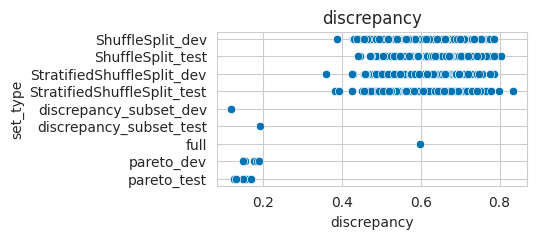

In [302]:
from scipy.stats import qmc
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("whitegrid")

discprecancies = {}
for set_id, points in df_crit_points.items():
    # print(set_id, points.shape)
    discprecancies[set_id] = qmc.discrepancy(points, method="WD",)
discrepancies = pd.Series(discprecancies)
discrepancies.index.name = "set"
discrepancies.name = "discrepancy"
discrepancies = discrepancies.reset_index()
discrepancies["set_type"] = discrepancies["set"].apply(get_set_type)
discrepancies

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
ax = sns.scatterplot(data=discrepancies, x="discrepancy", y="set_type", ax=ax)
# ax.set_yscale("log")
# ax.tick_params(axis='x', rotation=90)
ax.set_title("discrepancy")
ax.figure.savefig(f"../data/{scenario}_discrepancy.pdf", bbox_inches="tight")

In [286]:
import scipy.spatial as ss
import numpy as np

# calculate volume
volumes = {}
for set_id, crit_points in df_crit_points.items():
    print(set_id, crit_points.shape)
    hull = ss.ConvexHull(crit_points)
    volumes[set_id] = hull.volume
volumes = pd.Series(volumes)
volumes

class_ShuffleSplit_split_0_seed_0_subset_dev (27, 3)
class_ShuffleSplit_split_0_seed_0_subset_test (28, 3)
class_ShuffleSplit_split_0_seed_1_subset_dev (27, 3)
class_ShuffleSplit_split_0_seed_1_subset_test (30, 3)
class_ShuffleSplit_split_0_seed_2_subset_dev (28, 3)
class_ShuffleSplit_split_0_seed_2_subset_test (31, 3)
class_ShuffleSplit_split_0_seed_3_subset_dev (28, 3)
class_ShuffleSplit_split_0_seed_3_subset_test (27, 3)
class_ShuffleSplit_split_0_seed_4_subset_dev (30, 3)
class_ShuffleSplit_split_0_seed_4_subset_test (31, 3)
class_ShuffleSplit_split_10_seed_0_subset_dev (28, 3)
class_ShuffleSplit_split_10_seed_0_subset_test (29, 3)
class_ShuffleSplit_split_10_seed_1_subset_dev (30, 3)
class_ShuffleSplit_split_10_seed_1_subset_test (30, 3)
class_ShuffleSplit_split_10_seed_2_subset_dev (28, 3)
class_ShuffleSplit_split_10_seed_2_subset_test (28, 3)
class_ShuffleSplit_split_10_seed_3_subset_dev (29, 3)
class_ShuffleSplit_split_10_seed_3_subset_test (29, 3)
class_ShuffleSplit_split_10_s

class_ShuffleSplit_split_0_seed_0_subset_dev                    0.067513
class_ShuffleSplit_split_0_seed_0_subset_test                   0.093113
class_ShuffleSplit_split_0_seed_1_subset_dev                    0.046456
class_ShuffleSplit_split_0_seed_1_subset_test                   0.016471
class_ShuffleSplit_split_0_seed_2_subset_dev                    0.006064
                                                                  ...   
pareto_hardest_class_ShuffleSplit_split_0_seed_2_subset_test    0.078146
pareto_hardest_class_ShuffleSplit_split_0_seed_3_subset_dev     0.104497
pareto_hardest_class_ShuffleSplit_split_0_seed_3_subset_test    0.080498
pareto_hardest_class_ShuffleSplit_split_0_seed_4_subset_dev     0.080993
pareto_hardest_class_ShuffleSplit_split_0_seed_4_subset_test    0.103956
Length: 1083, dtype: float64

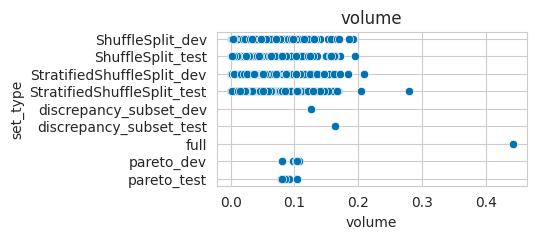

In [301]:
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("whitegrid")

volumes.index.name = "set"
volumes.name = "volume"
df_vol = volumes.reset_index()

df_vol["set_type"] = df_vol["set"].apply(get_set_type)

fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
ax = sns.scatterplot(data=df_vol, x="volume", y="set_type", ax=ax)
# ax.set_yscale("log")
# ax.tick_params(axis='x', rotation=45)
ax.set_title("volume")
ax.figure.savefig(f"../data/{scenario}_volume.pdf", bbox_inches="tight")

In [277]:
# _df = pd.concat([df, df_new]).reset_index(drop=True)
_df = df_new

In [278]:
%%capture --no-display
from autorank._util import get_sorted_rank_groups, RankResult
from carps.analysis.plot_ranking import calc_critical_difference

rank_results = {}
for (scenario, set_id), gdf in _df.groupby(by=["scenario", "set"]):
    perf_col: str = "trial_value__cost_inc_norm"
    identifier = f"{scenario}_{set_id}"
    result = calc_critical_difference(gdf, identifier=identifier, figsize=(8, 3), perf_col=perf_col, plot_diagram=False)
    sorted_ranks, names, groups = get_sorted_rank_groups(result, reverse=False)
    rank_results[(scenario, set_id)] = result

ValueError: Data must be at least length 3.

In [279]:
R = []
for i, (k, v) in enumerate(rank_results.items()):
    d = pd.DataFrame({
        "scenario": k[0],
        "set": k[1],
        **v.rankdf["meanrank"]
    }, index=[i]
    ).melt(id_vars=["scenario", "set"], var_name="optimizer_id", value_name="meanrank")
    d["order"] = d.rank(method="max", numeric_only=True).astype(int)
    R.append(d)
    # break

df_rank = pd.concat(R).reset_index(drop=True)
df_rank = df_rank[df_rank["set"] != "full"]
df_rank

,scenario,set,optimizer_id,meanrank,order
0,blackbox,class_ShuffleSplit_split_0_seed_0_subset_dev,SMAC3-BlackBoxFacade,1.462963,1
1,blackbox,class_ShuffleSplit_split_0_seed_0_subset_dev,Nevergrad-CMA-ES,2.259259,2
2,blackbox,class_ShuffleSplit_split_0_seed_0_subset_dev,RandomSearch,2.277778,3
3,blackbox,class_ShuffleSplit_split_0_seed_0_subset_test,SMAC3-BlackBoxFacade,1.464286,1
4,blackbox,class_ShuffleSplit_split_0_seed_0_subset_test,Nevergrad-CMA-ES,2.178571,2
...,...,...,...,...,...
3244,blackbox,pareto_hardest_class_ShuffleSplit_split_0_seed...,RandomSearch,1.980769,2
3245,blackbox,pareto_hardest_class_ShuffleSplit_split_0_seed...,Nevergrad-CMA-ES,2.884615,3
3246,blackbox,pareto_hardest_class_ShuffleSplit_split_0_seed...,SMAC3-BlackBoxFacade,1.034483,1
3247,blackbox,pareto_hardest_class_ShuffleSplit_split_0_seed...,RandomSearch,2.034483,2


In [280]:

is_different = {}
for scenario, gdf in df_rank.groupby(by="scenario"):
    set_origins = gdf["set"].apply(lambda x: "_".join(x.split("_")[:-2])).unique()   
    for set_origin in set_origins:
        origs = original_optimizers[scenario]
        df_dev = gdf[gdf["set"] == f"{set_origin}_subset_dev"]
        df_test = gdf[gdf["set"] == f"{set_origin}_subset_test"]
        order_dev = []
        order_test = []
        for orig in origs:
            order_dev.append(df_dev[df_dev["optimizer_id"] == orig]["order"].values[0])
            order_test.append(df_test[df_test["optimizer_id"] == orig]["order"].values[0])
        _is_different = order_dev != order_test
        is_different[(scenario, set_origin)] = _is_different
is_different

{('blackbox', 'class_ShuffleSplit_split_0_seed_0'): False,
 ('blackbox', 'class_ShuffleSplit_split_0_seed_1'): True,
 ('blackbox', 'class_ShuffleSplit_split_0_seed_2'): False,
 ('blackbox', 'class_ShuffleSplit_split_0_seed_3'): True,
 ('blackbox', 'class_ShuffleSplit_split_0_seed_4'): False,
 ('blackbox', 'class_ShuffleSplit_split_10_seed_0'): True,
 ('blackbox', 'class_ShuffleSplit_split_10_seed_1'): True,
 ('blackbox', 'class_ShuffleSplit_split_10_seed_2'): False,
 ('blackbox', 'class_ShuffleSplit_split_10_seed_3'): False,
 ('blackbox', 'class_ShuffleSplit_split_10_seed_4'): True,
 ('blackbox', 'class_ShuffleSplit_split_11_seed_0'): False,
 ('blackbox', 'class_ShuffleSplit_split_11_seed_1'): False,
 ('blackbox', 'class_ShuffleSplit_split_11_seed_2'): False,
 ('blackbox', 'class_ShuffleSplit_split_11_seed_3'): True,
 ('blackbox', 'class_ShuffleSplit_split_11_seed_4'): True,
 ('blackbox', 'class_ShuffleSplit_split_12_seed_0'): True,
 ('blackbox', 'class_ShuffleSplit_split_12_seed_1'): 

In [293]:
df_diff = pd.Series({k[1]: v for k, v in is_different.items()})
df_diff.index.name = "origin_detail"
df_diff.name = "is_different"
df_diff = df_diff.reset_index()
df_diff["is_different"] = df_diff["is_different"].astype(int)
def get_origin(x: str) -> str:
    if x.startswith("class"):
        return x.split("_")[1]
    elif x.startswith("pareto"):
        return "pareto"
    else:
        return x
df_diff["origin"] = df_diff["origin_detail"].apply(get_origin)
df_diff

df_diff_reduced = df_diff.groupby(by="origin").agg({"is_different": "sum"}).reset_index()
n_total_splits = n_splits * len(seeds)
df_diff_reduced["fraction_is_different"] = df_diff_reduced["is_different"] / n_total_splits
df_diff_reduced.to_latex(f"../data/{scenario}_is_different.tex", index=False)
df_diff_reduced

,origin,is_different,fraction_is_different
0,ShuffleSplit,125,0.471698
1,StratifiedShuffleSplit,122,0.460377
2,discrepancy,0,0.000000
3,pareto,0,0.000000


In [218]:
import pandas as pd
import numpy as np



fn_template = "ranks_per_set_{scenario}_{set_origin}.csv"

decimal_places = 2

final_str = r"""
\begin{{table}}[h]
    \caption{{{caption}}}
    \label{{{label}}}
    \centering
    %\resizebox{{0.4\textwidth}}{{!}}{{
    {table_string}
    %}}
\end{{table}}
"""

float_format = lambda x: ("{:0." + str(decimal_places) + "f}").format(x) if not np.isnan(x) else "-"


for scenario, gdf in df_rank.groupby("scenario"):
    set_origins = gdf["set"].apply(lambda x: "_".join(x.split("_")[:-2])).unique()   
    for set_origin in set_origins:    
        fn = fn_template.format(scenario=scenario, set_origin=set_origin)


        sorter = gdf[gdf["set"] == set_origin + "_subset_dev"].sort_values("meanrank")["optimizer_id"].to_list()

        _gdf = gdf[gdf["set"].apply(lambda x: x.startswith(set_origin))].copy()
        R = _gdf.pivot_table(index="set", columns="optimizer_id", values="order").map(int)
        origs = original_optimizers[scenario]
        origs.sort(key=lambda x: sorter.index(x))
        cols = origs + [c for c in R.columns if c not in original_optimizers[scenario]]
        R = R[cols]


        MR = _gdf.pivot_table(index="set", columns="optimizer_id", values="meanrank").map(lambda x: f"{x:.2f}" if not isinstance(x, str) else x)
        MR = MR[cols]
        for i, ((idx, row), (idx2, row2)) in enumerate(zip(MR.iterrows(), R.iterrows())):
            for j in range(len(row)):
                row.iloc[j] = row.iloc[j] + f" ({int(row2.iloc[j])})"

        print(MR)
        # table_str = MR.to_latex(float_format=float_format, na_rep="-").strip()
        # caption = f"Mean Ranking for Scenario {scenario}"
        # label = f"tab:ranking_validation_{scenario}"
        # table_str = final_str.format(table_string=table_str, label=label, caption=caption)
        # table_str = table_str.replace("_", "\_")

        # with open(fn + ".tex", "w") as file:
        #     file.write(table_str)
        # print(table_str)

optimizer_id                                  SMAC3-BlackBoxFacade  \
set                                                                  
class_ShuffleSplit_split_0_seed_0_subset_dev              1.46 (1)   
class_ShuffleSplit_split_0_seed_0_subset_test             1.46 (1)   

optimizer_id                                  Nevergrad-CMA-ES RandomSearch  
set                                                                          
class_ShuffleSplit_split_0_seed_0_subset_dev          2.26 (2)     2.28 (3)  
class_ShuffleSplit_split_0_seed_0_subset_test         2.18 (2)     2.36 (3)  
optimizer_id                                  SMAC3-BlackBoxFacade  \
set                                                                  
class_ShuffleSplit_split_0_seed_1_subset_dev              1.48 (1)   
class_ShuffleSplit_split_0_seed_1_subset_test             1.27 (1)   

optimizer_id                                  Nevergrad-CMA-ES RandomSearch  
set                                             

In [219]:
# from pathlib import Path
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
# from carps.utils.pareto_front import pareto

# def read_set(fn: Path) -> pd.DataFrame:
#     df = pd.read_csv(fn)
#     df["problem_id"] = df["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
#     df["benchmark_id"] = df["problem_id"].apply(lambda x: x.split("/")[0])
#     df = df.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")    
#     return df

# performance_fn = Path("/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/BB/default/df_crit.csv")
# performance = pd.read_csv(performance_fn)
# performance["problem_id"] = performance["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
# problem_ids = list(performance["problem_id"])
# n_problems = len(problem_ids)
# subset_size = 30

# rankings = []

# performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
# p_cols = [c for c in performance.columns if c not in ["problem_id", "benchmark_id"]]
# performance = performance.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")


# path_subset_dev = performance_fn.parent / f"subset_{subset_size}.csv"
# subset_dev = read_set(path_subset_dev)

# path_subset_test = performance_fn.parent / f"subset_complement_subset_{subset_size}.csv"
# subset_test = read_set(path_subset_test)

# problem_ids_dev = subset_dev["problem_id"].to_list()
# problem_ids_test = subset_test["problem_id"].to_list()

# seeds = np.arange(0, 10)
# performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
# benchmark_ids = list(performance["benchmark_id"].unique())


# def add_rank(df: pd.DataFrame) -> pd.DataFrame:
#     D = []
#     for problem_id, gdf in df.groupby(["problem_id"]):
#         pivot = gdf.pivot(index=["problem_id", "benchmark_id"], columns="optimizer_id", values="performance").reset_index()
#         if not all([p in pivot.columns for p in p_cols]):
#             print(gdf.columns)
#             continue
#         rank = pivot[p_cols].rank(axis=1).melt(value_vars=p_cols, var_name="optimizer_id", value_name="rank")
#         gdf = pd.merge(gdf, rank, on=["optimizer_id"])
#         D.append(gdf)
#     D = pd.concat(D).reset_index(drop=True)
#     return D

# def get_ranking(df: pd.DataFrame, set_id: str, split: int = -1, seed: int = -1) -> pd.DataFrame:
#     df = add_rank(df)
#     df["set"] = set_id
#     df["split"] = split
#     df["seed"] = seed
#     return df


# rankings = []

# aggregate_func = np.mean

# mean_ranking_full = get_ranking(performance, "full")
# rankings.append(mean_ranking_full)

# mean_ranking_dev = get_ranking(subset_dev, "discrepancy_dev")
# rankings.append(mean_ranking_dev)

# mean_ranking_test = get_ranking(subset_test, "discrepancy_test")
# rankings.append(mean_ranking_test)  

# n_splits = n_problems // (subset_size * 2)
# print(n_splits)
# X = performance.values
# y = performance["benchmark_id"].to_numpy()

# split_classes = [StratifiedShuffleSplit, ShuffleSplit]

# # for split_class in split_classes:
# #     for seed in seeds:
# #         sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
# #         sss.get_n_splits(X, y)
# #         for i, (train_index, test_index) in enumerate(sss.split(X, y)):
# #             D_dev = performance.iloc[train_index]
# #             D_dev = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
# #             rankings.append(D_dev)

# #             D_test = performance.iloc[test_index]
# #             D_test = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
# #             rankings.append(D_test)


# df_ranking = pd.concat(rankings).reset_index(drop=True)

In [220]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_style("whitegrid")
# sns.set_palette("colorblind")

# gdf = df_ranking
# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(111)
# ax = sns.violinplot(data=gdf, x="optimizer_id", y="rank", hue="set", cut=0, ax=ax)
# # ax.set_title(f"use_mean: {gid}")
# plt.show()

In [221]:
# gdf = df_ranking
# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(111)
# ax = sns.histplot(data=gdf, x="performance", hue="optimizer_id", ax=ax,  element="step")
# ax = fig.add_subplot(211)
# ax = sns.histplot(data=gdf, x="rank", hue="optimizer_id", ax=ax,  element="step")
# # ax.set_title(f"use_mean: {gid}")
# plt.show()

In [222]:
# def distance_bhattacharaya(p, q):
#     return -np.log(np.sum(np.sqrt(p*q)))

# def distance_kullback_leibler(p, q):
#     return np.sum(p * np.log(p / q))

# # Performance
# distances = {}
# bin_edges = None
# for gid, gdf in df_ranking.groupby(["optimizer_id", "set"]):
#     values = gdf["performance"].values
#     q = np.histogram(values, bins=20, range=[0,1], density=True)
#     bin_edges = q[1]
#     distances[gid] = q[0]

# distributions = pd.DataFrame(distances).T
# distributions.index.name = ("optimizer_id", "set")
# distributions = distributions.reset_index(names=["optimizer_id", "set"])
# # print(distributions.columns)

# dist = {}
# for gid, gdf in distributions.groupby(by=["optimizer_id", "set"]):
#     for gid2, gdf2 in distributions.groupby(by=["optimizer_id", "set"]):
#         if gid[0] != gid2[0]:
#             continue
#         p = gdf.iloc[0].values[2:].astype(float)
#         q = gdf2.iloc[0].values[2:].astype(float)
#         d = distance_bhattacharaya(p, q)
#         # print(f"{gid} vs {gid2}: {d}")
#         dist[(gid, gid2)] = d

# heatmaps = {}
# n_sets = distributions["set"].nunique()
# sets = distributions["set"].unique()
# for ((opt, set_id), (opt, set_id2)), distance in dist.items():
#     # print(f"{opt} {set_id} vs {set_id2}: {distance}") 
#     if not opt in heatmaps:
#         heatmaps[opt] = np.zeros((n_sets, n_sets))
#     heatmaps[opt][np.where(sets == set_id)[0][0], np.where(sets == set_id2)[0][0]] = distance

# fig = plt.figure(figsize=(12, 4))
# axes = fig.subplots(1, len(heatmaps), sharex=True, sharey=True)
# for i, (opt, heatmap) in enumerate(heatmaps.items()):
#     ax = axes[i]
#     sns.heatmap(heatmap, ax=ax, xticklabels=sets, yticklabels=sets)
#     ax.set_title(opt)
# plt.show()

In [223]:


 
# for use_mean in [False]:
#     aggregate_func = lambda x: x
#     if use_mean:
#         aggregate_func = np.mean

    

#     mean_ranking_full = performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_full = performance[p_cols]
#     mean_ranking_full["problem_id"] = performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_full["set"] = "full"
#     mean_ranking_full["split"] = -1
#     mean_ranking_full["seed"] = -1
#     mean_ranking_full["use_mean"] = use_mean
#     mean_ranking_full = melt(mean_ranking_full)
#     mean_ranking_full = add_performance(mean_ranking_full)
    

#     mean_ranking_dev = subset_dev[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_dev["problem_id"] = subset_dev["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_dev["set"] = "discrepancy_dev"
#     mean_ranking_dev["split"] = -1
#     mean_ranking_dev["seed"] = -1
#     mean_ranking_dev["use_mean"] = use_mean
#     mean_ranking_dev = melt(mean_ranking_dev)
#     mean_ranking_dev = add_performance(mean_ranking_dev)

#     mean_ranking_test = subset_test[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_test["problem_id"] = subset_test["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_test["set"] = "discrepancy_test"
#     mean_ranking_test["split"] = -1
#     mean_ranking_test["seed"] = -1
#     mean_ranking_test["use_mean"] = use_mean
#     mean_ranking_test = melt(mean_ranking_test)
#     mean_ranking_test = add_performance(mean_ranking_test)

#     # easiest
#     costs = performance[p_cols].values
#     ids = pareto(-costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_easiest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_easiest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_easiest["set"] = "pareto_full_easiest"
#     mean_ranking_pareto_easiest["split"] = -1
#     mean_ranking_pareto_easiest["seed"] = -1
#     mean_ranking_pareto_easiest["use_mean"] = use_mean
#     mean_ranking_pareto_easiest = melt(mean_ranking_pareto_easiest)
#     mean_ranking_pareto_easiest = add_performance(mean_ranking_pareto_easiest)

#     # hardest
#     costs = performance[p_cols].values
#     ids = pareto(costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_hardest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_hardest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_hardest["set"] = "pareto_full_hardest"
#     mean_ranking_pareto_hardest["split"] = -1
#     mean_ranking_pareto_hardest["seed"] = -1
#     mean_ranking_pareto_hardest["use_mean"] = use_mean
#     mean_ranking_pareto_hardest = melt(mean_ranking_pareto_hardest)
#     mean_ranking_pareto_hardest = add_performance(mean_ranking_pareto_hardest)



#     ranking = []
#     ranking.append(mean_ranking_full)
#     ranking.append(mean_ranking_dev)
#     ranking.append(mean_ranking_test)
#     ranking.append(mean_ranking_pareto_easiest)
#     ranking.append(mean_ranking_pareto_hardest)

#     n_splits = n_problems // (subset_size * 2)
#     print(n_splits)
#     X = performance.values
#     y = performance["benchmark_id"].to_numpy()

#     split_classes = [StratifiedShuffleSplit, ShuffleSplit]

#     for split_class in split_classes:
#         for seed in seeds:
#             sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
#             sss.get_n_splits(X, y)
#             for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#                 D_dev = performance.iloc[train_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_dev["problem_id"] = performance.iloc[train_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_dev["set"] = f"{split_class.__name__}_dev"
#                 D_dev["split"] = i
#                 D_dev["seed"] = seed
#                 D_dev["use_mean"] = use_mean
#                 D_dev = melt(D_dev)
#                 D_dev = add_performance(D_dev)
                
#                 D_test = performance.iloc[test_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_test["problem_id"] = performance.iloc[test_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_test["set"] = f"{split_class.__name__}_test"
#                 D_test["split"] = i
#                 D_test["seed"] = seed
#                 D_test["use_mean"] = use_mean
#                 D_test = melt(D_test)
#                 D_test = add_performance(D_test)
#                 ranking.extend([D_dev, D_test])

#     df_ranking = pd.DataFrame(ranking) if use_mean else pd.concat(ranking).reset_index(drop=True)
#     df_ranking = df_ranking.melt(id_vars=["set", "split", "seed", "problem_id", "use_mean"], value_vars=p_cols, var_name="optimizer_id", value_name="rank")
#     rankings.append(df_ranking)

# df_ranking = pd.concat(rankings).reset_index(drop=True)
# df_ranking
